In [41]:
from ACNet_v1 import ACNet
from ACNet_v1 import ReplayMemory
import FireFightingEnv as FFEnv
import torch
import torch.optim as optim
import random
import math
import time
from collections import namedtuple, deque
from itertools import count
import torch.nn as nn
import imageio

test_num=7
model_name = 'PG'

AGT_COUNT = 3
GRID_SIZE = 5

def test_model(policy_net, env, num_episodes=10):
    policy_net.eval()  # 将模型设为评估模式
    fire_frames = []
    fire_agent_frames = []
    env_frames = []

    for i_episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        while True:
            # 对每个agent进行推断
            actions = []
            for s in state:
                input = torch.from_numpy(s[0]).float().to(device)  # 将state转换为tensor
                water_res = torch.tensor([[s[1]]]).float().to(device)
                action_i = policy_net(input.unsqueeze(0), water_res).max(1)[1].view(1, 1)
                action_int = action_i.item()
                action = [action_int % 5, int(action_int / 5)]
                actions.append(action)

            # 执行动作
            next_state, reward, done = env.step(actions)

            # 更新总奖励
            total_reward += sum(reward)

            # 更新当前状态
            state = next_state

            fire_frames.append(env.mapEnv.figFire())
            env_frames.append(env.mapEnv.figEnv())
            fire_agent_frames.append(env.mapEnv.figFireAgent())
            
            
            # 如果episode结束，则打印总奖励并退出循环
            if done:
                print(f"Episode {i_episode + 1}, Total Reward: {total_reward}")
                imageio.mimsave('./results/gif/environment' + model_name + str(test_num) + '.gif', env_frames, duration=0.5)
                # imageio.mimsave('./results/gif/fire.gif', fire_frames, duration=0.5)
                imageio.mimsave('./results/gif/fire_agent' + model_name + str(test_num) + '.gif', fire_agent_frames, duration=0.5)
                break




In [42]:
# 创建环境
env = FFEnv.FFEnv(3)  # 请用你实际使用的环境类来替代

# 创建模型实例
policy_net = ACNet(10, GRID_SIZE)  # 请用你实际使用的神经网络类来替代

# 加载模型参数
checkpoint = torch.load('./results/checkpoint/Run'+ model_name  + str(test_num) + '.pth')  # 请用你实际的模型文件路径来替代
policy_net.load_state_dict(checkpoint)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net.to(device)


ACNet(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1a): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 116, kernel_size=(3, 3), stride=(1, 1))
  (fc0): Linear(in_features=1, out_features=12, bias=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc_policy): Linear(

In [43]:
TEST_ALL = 0
if(TEST_ALL):
    test_model(policy_net, env, num_episodes=1)


In [44]:
TEST_VIEW_SINGLE_STEP = 1
if(TEST_VIEW_SINGLE_STEP):
    policy_net.eval()  # 将模型设为评估模式

    state = env.reset()
    total_reward = 0

[[0, 0], [0, 0], [0, 0]]
[ 0.  -0.6 -0.6]


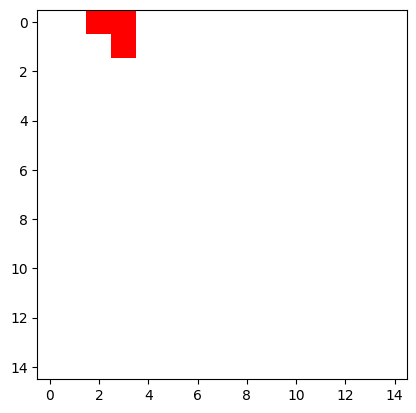

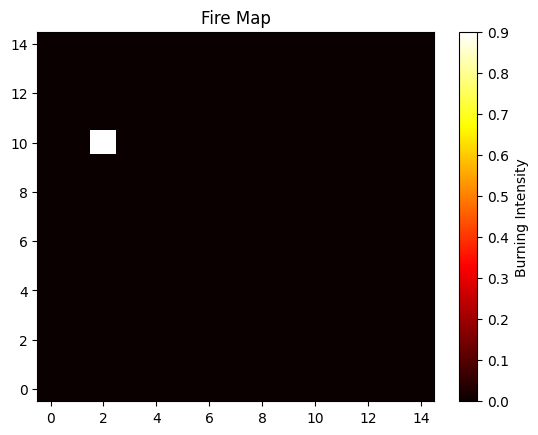

In [45]:
fire_agent_frames = []

if(TEST_VIEW_SINGLE_STEP):
    # 对每个agent进行推断
    actions = []
    for s in state:
        input = torch.from_numpy(s[0]).float().to(device)  # 将state转换为tensor
        water_res = torch.tensor([[s[1]]]).float().to(device)
        if model_name == '':
            action_i = policy_net(input.unsqueeze(0), water_res).max(1)[1].view(1, 1)
        elif model_name == 'PG':
            action_i = torch.argmax(policy_net(input.unsqueeze(0), water_res).max(1)[1].view(1, 1))
        else:
            raise Exception
        action_int = action_i.item()
        action = [action_int % 5, int(action_int / 5)]
        actions.append(action)
    print(actions)
    
    # 执行动作
    next_state, reward, done = env.step(actions)
    # print(next_state)
    print(reward)
    env.mapEnv.plotAgent()
    # env.mapEnv.plotAll()
    env.mapEnv.plotFireMap()

    fire_agent_frames.append(env.mapEnv.figFireAgent())

    # 更新总奖励
    total_reward += sum(reward)

    # 更新当前状态
    state = next_state

    # 如果episode结束，则打印总奖励并退出循环
    if done:
        print("DONE")
        imageio.mimsave('fire_agent.gif', fire_agent_frames, duration=0.5)